#### Author
Zalina Rusinova

#### Reference
[Notion ticket](https://www.notion.so/a74951e4e815480584dea7d61ddce6cc?v=dbfdb1207d0e451b827d3c5041ed0cfd&p=141d322a8f1a421fbb801755ea55caec)

#### Idea
Test different ways of data augmentation 

#### Data
4500 cryptonews titles labeled as positive, neutral or negative – zipped pwd-protected [CSV](https://drive.google.com/file/d/1Apr3YPZVf0kOJ5Pc1RYDoQxTdjJPbnt4/view?usp=sharing) (not to be shared outside of the project!)

#### Result
So far, it has not been possible to achieve an increase in accuracy by any of tried methods of data augmentation.

In [1]:
from datasets import load_dataset, load_metric
from transformers import (
    TrainingArguments, Trainer, 
    AdamW, get_scheduler,
    AutoModelForSequenceClassification,
    AutoTokenizer
)

import pandas as pd
import numpy as np
from copy import deepcopy
import matplotlib.pyplot as plt
import yaml
from importlib import import_module

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from typing import Dict, Any, Tuple, List, Union, Callable

import torch
from torch import Tensor
from torch.utils.data import Dataset, DataLoader

import pytorch_lightning as pl
from pytorch_lightning import Trainer as Pl_trainer
from pytorch_lightning import seed_everything, Callback
from sklearn.metrics import classification_report

import nlpaug.augmenter.word as naw

import nltk
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')


import warnings
warnings.filterwarnings('ignore')

import logging
logging.disable(logging.INFO)
logging.disable(logging.WARNING)

import copy



seed_everything(42)

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/zalina/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /home/zalina/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


42

### Read data

In [2]:
DATA_PATH = '../data/20190110_train_4500.csv'

In [3]:
dataset = pd.read_csv(DATA_PATH)

In [4]:
dataset.head()

,title,sentiment
0,Bitcoin Market Has Run Out of Juice: Cryptocur...,Negative
1,Bitcoin Core 0.14.0 Speeds Up Blockchain Synci...,Positive
2,Thinking of Travelling With Bitcoin? With Thes...,Positive
3,Investors Carried Out Mental Gymnastics to Jus...,Negative
4,"Bitcoin Price Holds Above $8,500 as Market Fig...",Positive


In [5]:
le = LabelEncoder()

dataset["label"] = le.fit_transform(dataset["sentiment"])

### Config

In [6]:
def build_object(
    object_cfg: Dict[str, Any], 
    is_hugging_face: bool = False, 
    **kwargs: Dict[str, Any]
) -> Callable:
    if "class" not in object_cfg.keys():
        raise ValueError("class key schould be in config")

    if "params" in object_cfg.keys():
        params = object_cfg["params"]

        for key, val in params.items():
            kwargs[key] = val
    else:
        params = {}
    
    if is_hugging_face:
        return get_instance(object_cfg["class"]).from_pretrained(**kwargs)
    
    return get_instance(object_cfg["class"])(**kwargs)


def get_instance(object_path: str) -> Callable:

    module_path, class_name = object_path.rsplit(".", 1)
    module = import_module(module_path)

    return getattr(module, class_name)

In [7]:
pl_cfg_str = """
epochs: 3
train_batch_size: 32
val_batch_size: 64
seed: 42

model_name: &model_name distilbert-base-uncased

tokenizer:
    class: transformers.DistilBertTokenizerFast
    params:
        pretrained_model_name_or_path: *model_name

model:
    class: transformers.DistilBertForSequenceClassification
    params:
        pretrained_model_name_or_path: *model_name
        num_labels: 3

optimizer:
    class: transformers.AdamW
    params:
        lr: 0.00005
        weight_decay: 0.001

scheduler:
    params:
        name: linear
        num_warmup_steps: 500
"""

huggingface_cfg_str = """
training_args:
    class: transformers.TrainingArguments
    params:
        output_dir: './test_trainer'
        num_train_epochs: 3
        per_device_train_batch_size: 32
        per_device_eval_batch_size: 64
        warmup_steps: 500                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   
        weight_decay: 0.001
        logging_steps: 10
        evaluation_strategy: epoch


model_name: &model_name distilbert-base-uncased

tokenizer:
    class: transformers.DistilBertTokenizerFast
    params:
        pretrained_model_name_or_path: *model_name

model:
    class: transformers.DistilBertForSequenceClassification
    params:
        pretrained_model_name_or_path: *model_name
        num_labels: 3
"""

In [8]:
pl_cfg = yaml.safe_load(pl_cfg_str)
huggingface_cfg = yaml.safe_load(huggingface_cfg_str)

### Preprocess/split

In [9]:
class FinNewsDataset(Dataset):
    def __init__(self, encodings: Dict[str, Any], labels: list):
        self.encodings = encodings
        self.labels = labels
    
    def __getitem__(self, idx: int) -> Dict[str, Any]:
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        
        return item
    
    def __len__(self) -> int:
        return len(self.labels)

In [10]:
def prepare_dataset(cfg: Dict[str, Any], data: list, labels: list) -> Dataset:
    
    tokenizer = build_object(cfg["tokenizer"], is_hugging_face=True)
    
    encodings = tokenizer(data, truncation=True, padding=True)
    
    return FinNewsDataset(encodings, labels)

In [11]:
def split_train_val(dataset: pd.DataFrame, test_size: float = 0.2) -> Tuple[list, ...]:
    train_data, val_data, train_labels, val_labels = train_test_split(
        dataset["title"].values, 
        dataset["label"].values,
        test_size=test_size
    )
    
    return train_data.tolist(), val_data.tolist(), train_labels.tolist(), val_labels.tolist()

In [12]:
train_data, val_data, train_labels, val_labels = split_train_val(dataset)

## Augmentation of training dataset

In [13]:
def get_augmented_data(
    augmenter,
    aug_kwargs: Dict[str, Any] = {},
    init_texts: List[str] = train_data,
    init_labels: List[str] = train_labels,
)-> Tuple[list, ...]:
    aug_text_data = []
    aug_text_lables = []
    
    for text, label in zip(init_texts,init_labels):
        aug_text_data.append(text)
        aug_text_lables.append(label)
        aug_result = augmenter.augment(text,**aug_kwargs)
        print(aug_result)
        
        if type(aug_result) == str:
            aug_text_data.append(aug_result)
            aug_text_lables.append(label)
            
        else:
            for line in aug_result:
                aug_text_data.append(line)
                aug_text_lables.append(label)
                      
    return aug_text_data, aug_text_lables

### 1. Back Translation Augmenter

Back-translation is translating target language to source language and mixing both original source sentence and back-translated sentence to train a model. 

In [14]:
back_translation_aug = naw.BackTranslationAug(
    from_model_name='facebook/wmt19-en-de', 
    to_model_name='facebook/wmt19-de-en'
)

In [15]:
%%time
%%capture
train_data_back_translation, label_data_back_translation = get_augmented_data(
    augmenter = back_translation_aug 
)

CPU times: user 9h 44min 57s, sys: 11min 19s, total: 9h 56min 17s
Wall time: 1h 15min 44s


In [16]:
train_data_back_translation[:10]

['Nasdaq Chief Executive Offers a Rare Bullish Outlook on Bitcoin',
 'Nasdaq chief offers rare bullish outlook on bitcoin',
 'Coinbase Wins Patent for Secure Bitcoin Payments System',
 'Coinbase wins patent for secure Bitcoin payment system',
 'Charts: Bitcoins Golden Price Streak Comes to a Close',
 "Charts: Bitcoin's golden track is coming to an end",
 'Bitcoin Payroll Startup Bitwage Launches UK Services',
 'Bitcoin payroll startup Bitwage launches UK services',
 'Hacker Compromises Bitcoin Wallet KeepKey Founders Email, Demands 30 BTC Ransom',
 "Hackers compromised Bitcoin Wallet KeepKey founder's email, demanding 30 BTC ransom"]

### 2. Synonym Augmenter

Substitute word by WordNet's synonym

In this example generating 2 augmented sentences with 3 synonyms (this parameters can be changed)

In [18]:
synonym_aug = naw.SynonymAug(aug_src='wordnet',aug_max=3)

In [19]:
%%time
%%capture
train_data_synonym_aug, label_data_synonym_aug = get_augmented_data(
    augmenter = synonym_aug,
    aug_kwargs = {'n':2},
)

CPU times: user 4.75 s, sys: 76.1 ms, total: 4.83 s
Wall time: 4.83 s


In [20]:
train_data_synonym_aug[:10]

['Nasdaq Chief Executive Offers a Rare Bullish Outlook on Bitcoin',
 'Nasdaq Chief Executive Offer a Uncommon Bullish Outlook on Bitcoin',
 'Nasdaq Gaffer Executive Offers a Uncommon Bullish Outlook on Bitcoin',
 'Coinbase Wins Patent for Secure Bitcoin Payments System',
 'Coinbase Wins Patent for Secure Bitcoin Payment System of rules',
 'Coinbase Wins Patent for Secure Bitcoin Payments Organization',
 'Charts: Bitcoins Golden Price Streak Comes to a Close',
 'Charts: Bitcoins Golden Terms Streak Come to a Closing curtain',
 'Charts: Bitcoins Golden Price Run Comes to a Finale',
 'Bitcoin Payroll Startup Bitwage Launches UK Services']

### 3. Contextual Word Embeddings Augmenter


Insert word by contextual word embeddings (in this case, it's BERT, but it can be DistilBERT, RoBERTA or XLNet)

In [21]:
CWEA_aug = naw.ContextualWordEmbsAug(
    model_path='bert-base-uncased', action="substitute")

In [22]:
%%time
%%capture
train_data_CWEA_aug, label_data_CWEA_aug = get_augmented_data(
    augmenter = CWEA_aug 
)

CPU times: user 53min 40s, sys: 9.48 s, total: 53min 50s
Wall time: 6min 43s


In [23]:
train_data_CWEA_aug[:10]

['Nasdaq Chief Executive Offers a Rare Bullish Outlook on Bitcoin',
 'nasdaq chief executive offers her complete practical influence on...',
 'Coinbase Wins Patent for Secure Bitcoin Payments System',
 'coinbase 1991 patent for electric bitcoin used online',
 'Charts: Bitcoins Golden Price Streak Comes to a Close',
 '2009 : bitcoins digital oldies trail comes to a close',
 'Bitcoin Payroll Startup Bitwage Launches UK Services',
 'the payroll startup project project uk 2007',
 'Hacker Compromises Bitcoin Wallet KeepKey Founders Email, Demands 30 BTC Ransom',
 'bt sells bitcoin credit for founders credit, for 30 btc ransom']

## Train pipeline

### Hugging Face api

In [24]:
def train_huggin_face_pipeline( 
    cfg,
    train_dataset: Dataset, 
    val_dataset: Dataset
):
    
    model = build_object(cfg["model"], is_hugging_face=True)
    
    training_args = build_object(cfg["training_args"])
    
    metric = load_metric("accuracy")
    
    def compute_metrics(eval_pred: tuple) -> dict:
    
        logits, labels = eval_pred
        predictions = np.argmax(logits, axis=-1)

        return metric.compute(predictions=predictions, references=labels)
    
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=compute_metrics
    )
    
    trainer.train()

### Pytorch-Lightning api

In [25]:
class SentimentPipeline(pl.LightningModule):
    """Class for training text classification models"""

    def __init__(self, cfg: Dict[str, Any], num_training_steps: int):
        super().__init__()
        
        self.cfg = cfg
        self.model = build_object(cfg["model"], is_hugging_face=True)
        self.metric = load_metric("accuracy")
        self.num_training_steps = num_training_steps
        
        self.metrics = []

    def configure_optimizers(self):
        optimizer = build_object(self.cfg["optimizer"], params=self.model.parameters())

        lr_scheduler = get_scheduler(
            optimizer=optimizer,
            num_training_steps=self.num_training_steps,
            **self.cfg["scheduler"]["params"]
        )

        scheduler = {
            "scheduler": lr_scheduler,
            "interval": "step",
            "frequency": 1,
        }

        return {"optimizer": optimizer, "lr_scheduler": scheduler}
    
    def forward(self, batch: Dict[str, Tensor]):
        return self.model(**batch)

    def training_step(self, batch: Dict[str, Tensor], batch_idx: int) -> Tensor:

        outputs = self.model(**batch)
        
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)
        self.metric.add_batch(predictions=predictions, references=batch["labels"])
        
        self.log(
            "train_acc",
            self.metric.compute()["accuracy"],
            on_step=False,
            on_epoch=True,
            prog_bar=True,
            logger=False,
        )
        
        self.log(
            "train_loss",
            outputs.loss,
            on_step=False,
            on_epoch=True,
            prog_bar=True,
            logger=False,
        )
        
        return outputs.loss

    def validation_step(self, batch: Dict[str, Tensor], batch_idx: int) -> None:

        with torch.no_grad():
            outputs = self.model(**batch)

        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)
        self.metric.add_batch(predictions=predictions, references=batch["labels"])
        
        self.log(
            "val_acc",
            self.metric.compute()["accuracy"],
            on_step=False,
            on_epoch=True,
            prog_bar=True,
            logger=False,
        )
        
        self.log(
            "val_loss",
            outputs.loss,
            on_step=False,
            on_epoch=True,
            prog_bar=True,
            logger=False,
        )

In [26]:
class MetricTracker(Callback):

    def __init__(self):
        self.collection = {
            "train_loss": [],
            "val_loss": [],
            "train_acc": [],
            "val_acc": []
        }
    
    def _log_metrics(self, trainer, stage: str = "train"):
        for key in (f"{stage}_acc", f"{stage}_loss"):
            self.collection[key].append(trainer.callback_metrics[key].item())
        
    def on_validation_epoch_end(self, trainer, module):
        self._log_metrics(trainer, "val")
    
    def on_train_epoch_end(self, trainer, module):
        self._log_metrics(trainer, "train")

In [27]:
def train_pl_model(
    cfg: Dict[str, Any], 
    train_dataloader: DataLoader, 
    val_dataloader: DataLoader, 
    return_predictions: bool = False
) -> Union[Dict[str, Any], Tuple[Dict[str, Any], np.ndarray]]:
    
    seed_everything(cfg["seed"])
    
    num_training_steps = cfg["epochs"] * len(train_dataloader)
    
    pipeline = SentimentPipeline(cfg, num_training_steps)
    
    metric_tracker = MetricTracker()
        
    trainer = Pl_trainer(
        max_epochs=cfg["epochs"],
        gpus=1,
        callbacks=[metric_tracker],
        num_sanity_val_steps=0
    )

    trainer.fit(
        pipeline, 
        train_dataloaders=train_dataloader, 
        val_dataloaders=val_dataloader
    )
    
    if return_predictions:
        outputs = trainer.predict(pipeline, val_dataloader)
        
        logits = torch.cat([p.logits for p in outputs])
        
        pred_labels = torch.argmax(logits, dim=-1).numpy()
        
        return metric_tracker.collection, pred_labels
    
    return metric_tracker.collection

### Cross-validation

In [28]:
def cross_val(
    cfg: Dict[str, Any], 
    dataset: pd.DataFrame, 
    n_splits: int = 3, 
    shuffle: bool = True
) -> List[float]:
    
    skf = StratifiedKFold(n_splits=n_splits, shuffle=shuffle, random_state=17)
    
    data = dataset["title"].values
    labels = dataset["label"].values
    
    cv_accuracy = []
        
    for train_index, test_index in skf.split(data, labels):
        
        train_data, val_data = data[train_index], data[test_index]
        train_labels, val_labels = labels[train_index], labels[test_index]
        
        train_dataset = prepare_dataset(cfg, train_data.tolist(), train_labels.tolist())
        val_dataset = prepare_dataset(cfg, val_data.tolist(), val_labels.tolist())
        
        train_dataloader = DataLoader(train_dataset, batch_size=cfg["train_batch_size"], shuffle=True)
        val_dataloader = DataLoader(val_dataset, batch_size=cfg["val_batch_size"], shuffle=False)
        
        scores = train_pl_model(cfg, train_dataloader, val_dataloader)
        
        cv_accuracy.append(scores["val_acc"][-1])
    
        torch.cuda.empty_cache()
    
    return cv_accuracy

## Val Learning Curve

In [29]:
def learning_curve(cfg: Dict[str, Any], dataset: pd.DataFrame, train_fracs: np.ndarray):
    
    train_sizes: List[int] = []
    val_scores: List[List[float]] = []
    
    num_points: int = len(train_fracs)
    
    for i in range(num_points):
        
        num_samples = int(len(dataset)*train_fracs[i])
        
        train_data = dataset[:num_samples]
        
        cv_score = cross_val(cfg, train_data)
        
        val_scores.append(cv_score)
        train_sizes.append(num_samples)
    
    return train_sizes, val_scores

In [30]:
# helper function

def plot_with_err(x, data, **kwargs):
    mu, std = data.mean(1), data.std(1)
    lines = plt.plot(x, mu, '-', **kwargs)
    plt.fill_between(x, mu - std, mu + std, edgecolor='none',
                     facecolor=lines[0].get_color(), alpha=0.2)
    plt.xlabel('train size')
    plt.ylabel('3-fold CV accuracy (mean +/- std)')
    plt.legend()
    plt.grid(True);
    plt.ylim(.5, 1)
    plt.title(f"4500 titles. {pl_cfg['model_name']} learning curves")

## Model Training with augmented training datasets

In [31]:
def get_trained_model(train_data,train_labels):
    hg_train_dataset = prepare_dataset(huggingface_cfg, train_data, train_labels)
    hg_val_dataset = prepare_dataset(huggingface_cfg, val_data, val_labels)
    train_huggin_face_pipeline(huggingface_cfg, hg_train_dataset, hg_val_dataset)

In [32]:
def get_scores_and_predictions(train_data,train_labels):
    pl_train_dataset = prepare_dataset(pl_cfg, train_data, train_labels)
    pl_val_dataset = prepare_dataset(pl_cfg, val_data, val_labels)
    
    train_dataloader = DataLoader(pl_train_dataset, batch_size=pl_cfg["train_batch_size"], shuffle=True)
    val_dataloader = DataLoader(pl_val_dataset, batch_size=pl_cfg["val_batch_size"], shuffle=False)
    
    scores, predictions = train_pl_model(pl_cfg, train_dataloader, val_dataloader, return_predictions=True)
    
    return scores, predictions, pl_val_dataset

### 1.Train with data, augmented with back_translation_aug

In [33]:
get_trained_model(train_data_back_translation, label_data_back_translation)

Epoch,Training Loss,Validation Loss,Accuracy
1,0.560300,0.560852,0.792536
2,0.373800,0.593572,0.789243
3,0.192400,0.630221,0.803513


In [34]:
model_scores_bt, model_predictions_bt,pl_val_dataset_bt = get_scores_and_predictions(train_data_back_translation, label_data_back_translation)

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 228it [00:00, ?it/s]

In [35]:
model_scores_bt

{'train_loss': [0.7976000308990479, 0.4296536445617676, 0.22993867099285126],
 'val_loss': [0.536617636680603, 0.5561700463294983, 0.6501085162162781],
 'train_acc': [0.6320340633392334, 0.8451825380325317, 0.9243755340576172],
 'val_acc': [0.8002195358276367, 0.8100987672805786, 0.7958287596702576]}

In [36]:
print(classification_report(pl_val_dataset_bt.labels, model_predictions_bt, target_names=le.classes_))

              precision    recall  f1-score   support

    Negative       0.79      0.89      0.84       307
     Neutral       0.67      0.56      0.61       172
    Positive       0.84      0.82      0.83       432

    accuracy                           0.80       911
   macro avg       0.77      0.76      0.76       911
weighted avg       0.79      0.80      0.79       911



### Cross_validation

In [37]:
cv_accuracy = cross_val(pl_cfg, dataset)

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [38]:
np.mean(cv_accuracy), np.std(cv_accuracy)

(0.7911726037661234, 0.0026893621272428185)

In [39]:
train_sizes, val_scores = learning_curve(pl_cfg, dataset, np.linspace(.2, 1, 5))

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

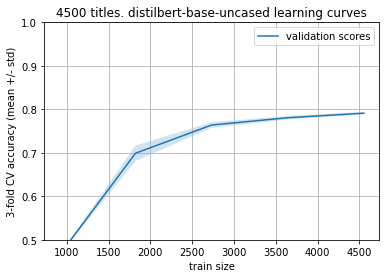

In [40]:
plot_with_err(train_sizes, np.array(val_scores), label='validation scores')

### 2.Train with data, augmented with synonym_aug

In [41]:
get_trained_model(train_data_synonym_aug,label_data_synonym_aug)

Epoch,Training Loss,Validation Loss,Accuracy
1,0.528300,0.557841,0.791438
2,0.212200,0.703915,0.799122
3,0.130100,0.909692,0.789243


In [42]:
model_scores_syn, model_predictions_syn,pl_val_dataset_syn = get_scores_and_predictions(train_data_synonym_aug,label_data_synonym_aug)

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 342it [00:00, ?it/s]

In [43]:
model_scores_syn

{'train_loss': [0.7189049124717712, 0.30794861912727356, 0.08614227920770645],
 'val_loss': [0.5391558408737183, 0.6837790012359619, 0.8215135335922241],
 'train_acc': [0.6803916096687317, 0.8911153674125671, 0.9751120805740356],
 'val_acc': [0.8013172149658203, 0.8035126328468323, 0.8002195358276367]}

In [44]:
print(classification_report(pl_val_dataset_syn.labels, model_predictions_syn, target_names=le.classes_))

              precision    recall  f1-score   support

    Negative       0.81      0.89      0.85       307
     Neutral       0.67      0.55      0.61       172
    Positive       0.84      0.83      0.84       432

    accuracy                           0.80       911
   macro avg       0.77      0.76      0.76       911
weighted avg       0.80      0.80      0.80       911



### Cross_validation

In [45]:
cv_accuracy = cross_val(pl_cfg, dataset)

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [46]:
np.mean(cv_accuracy), np.std(cv_accuracy)

(0.7911726037661234, 0.0026893621272428185)

In [47]:
train_sizes, val_scores = learning_curve(pl_cfg, dataset, np.linspace(.2, 1, 5))

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

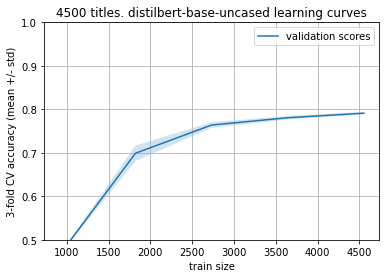

In [48]:
plot_with_err(train_sizes, np.array(val_scores), label='validation scores')

### 3.Train with data, augmented with CWEA_aug

In [49]:
get_trained_model(train_data_CWEA_aug, label_data_CWEA_aug)

Epoch,Training Loss,Validation Loss,Accuracy
1,0.697000,0.589581,0.783754
2,0.528600,0.522023,0.799122
3,0.325300,0.624812,0.790340


In [50]:
model_scores_CWEA, model_predictions_CWEA,pl_val_dataset_CWEA = get_scores_and_predictions(train_data_CWEA_aug, label_data_CWEA_aug)

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 228it [00:00, ?it/s]

In [51]:
model_scores_CWEA

{'train_loss': [0.8784877061843872, 0.5949651002883911, 0.37721672654151917],
 'val_loss': [0.5496178865432739, 0.5335216522216797, 0.6038290858268738],
 'train_acc': [0.585094690322876, 0.7629700899124146, 0.8624759912490845],
 'val_acc': [0.7980241775512695, 0.8013172149658203, 0.7936333417892456]}

In [52]:
print(classification_report(pl_val_dataset_CWEA.labels, model_predictions_CWEA, target_names=le.classes_))

              precision    recall  f1-score   support

    Negative       0.79      0.87      0.83       307
     Neutral       0.68      0.54      0.60       172
    Positive       0.83      0.84      0.84       432

    accuracy                           0.79       911
   macro avg       0.77      0.75      0.76       911
weighted avg       0.79      0.79      0.79       911



### Cross_validation

In [53]:
cv_accuracy = cross_val(pl_cfg, dataset)

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [54]:
np.mean(cv_accuracy), np.std(cv_accuracy)

(0.7911726037661234, 0.0026893621272428185)

In [55]:
train_sizes, val_scores = learning_curve(pl_cfg, dataset, np.linspace(.2, 1, 5))

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

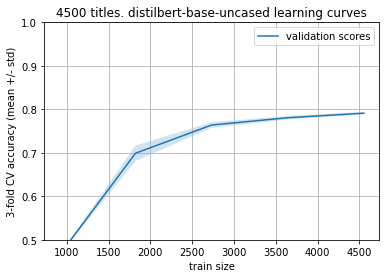

In [56]:
plot_with_err(train_sizes, np.array(val_scores), label='validation scores')